<a href="https://colab.research.google.com/github/ShreyaaChauhan/Deep_Learning_with_Pytorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

- data (prepare and load)
- build model
- fitting the model to the data (training)
- making predictions and evaluating a model (inference)
- saving and loading a model
- putting it all together



In [54]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt


# 1. Data Preparing and loading

- Excel spreadsheet
- Images of any kind
- Videos (Youtube has lots of data)
- Audio like songs or podcasts
- DNA
- Text

Machine Learning is a game of two parts:
1. get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.




In [55]:
# Linear Regression
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
Y = weight* X + bias

### Splitting data into training and test sets 

In [56]:
# Create a train /test split
train_split = int(0.8*len(X))
X_train, Y_train = X[: train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

In [57]:
def plot_predictions(train_data = X_train,
                     train_labels = Y_train,
                     test_data = X_test,
                     test_labels = Y_test,
                     predictions = None):
  # ===========================================================
  #    Plot training data, test data and compare predictions
  # ===========================================================
  plt.figure(figsize = (10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c= "b", s=4, label = "Trainning data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c= "g", s=4, label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data, predictions, c ="r", s=4, label="Predictions")

    #Show the legend
    plt.legend(prop={"size":14})


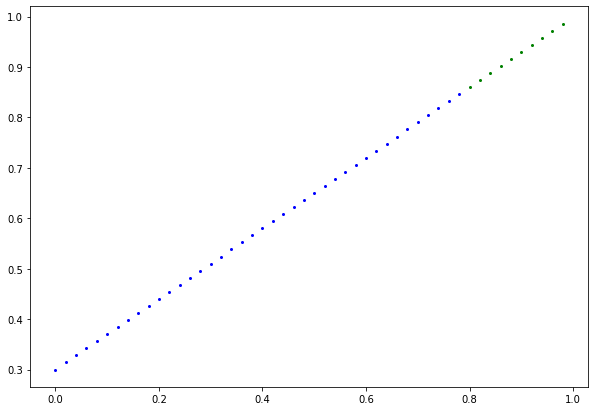

In [58]:
plot_predictions()

# Build model

**What our model does?**
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represnet (or get closer to) the ideal values (the weight & bias values we used to create the data)

**How does it do so?**

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [59]:
#Create linear regression model class
class LinearRegression(nn.Module): #<- almost everything in Pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, requires_grad = True,dtype= torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad = True, dtype= torch.float))

    # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x is the input data"
    return self.weights * x + self.bias # this is the linear regression formula


# Pytorch model building essentials


* torch.nn - conatins all of the building blocks for computational graphs (another word for neural networks)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in Pytorch live, they will help with the gradient descent
* torch.utils.data.Dataset - Represents a map between key (label) and sample (features) pairs of your data. Such as images and their associated labels
* torch.utils.data.DataLoader Creates a Python iterable over a torch Dataset(allow you to iterate over your data)
* def forward() - All nn.Module subclasses require you ti overwrite forward(), this method defines what happens in the forwards computation

### Checking the contents of our PyTorch model

In [60]:


# CReate an instance of the moce (this is a subclass of nn.Module)
model_0 = LinearRegression()

In [61]:
# List out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [62]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [63]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

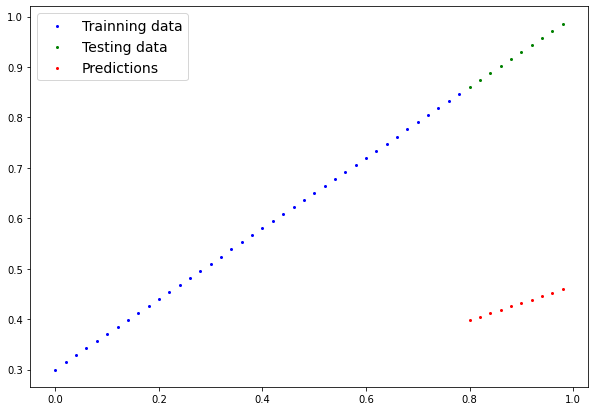

In [64]:
# Make predictions with model
with torch.inference_mode():
  Y_preds = model_0(X_test)
  
# You can also do something similar with torch.no)grad(), however, torch.inference_mode() is preferred
with torch.no_grad():
  Y_preds = model_0(X_test)

plot_predictions(predictions=Y_preds)

# Train model

The model idea of training is for a model to move from some *unknown* parameter (these may be random) to some *known* parameters

Or in other words from a poor representation of the data to a better representation

One way to measure how poor on how wrong your models predictions are is to use a loss function/ cost function/ criterion 

Things we need to train

**Loss function:** A function to measure how wrong your model's predictions are to the idel outputs, lower is better

**Optimizer:** Take into account the loss of a model and adjusts the model's parameters(e.g weight & bias) to improve the loss function

Inside the optimizer we'll often have to set two parameters:
- params - the model parameters we'd like to optimize. e.g `params = model_0.parameters()`

- lr (learning rate) - the learning rate is a hyperparameter tha defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in larger changes)


and specifically for PyTorch, we need:

- A training loop
- A testing loop

In [65]:
# Set up loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)

# Build a training loop (amd a testing loop) in PyTorch

Following are the things that we need in our training loop:-
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to the ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradiend descent**)


In [66]:
torch.manual_seed(42)
# An epoch is one loop through the data...
epochs = 200

#track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
  # 1. Foraward pass 
  y_pred = model_0(X_train)
  # 2. calculate the loss 
  loss = loss_fn(y_pred, Y_train)
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()
  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.. we have tp zero them above step 3
  
  #Testing 
  model_0.eval()# turns of different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): #turns off gradient tracking & a couple more things behind the scenes 
    # Do the forward pass
    test_pred = model_0(X_test)

    # Clculate the loss
    test_loss = loss_fn(test_pred, Y_test)
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict(), epoch)

  #print(model_0.state_dict(), epoch)

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))]) 0
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))]) 10
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))]) 20
Epoch: 30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))]) 30
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))]) 40
Epoch: 50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))]) 50
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias

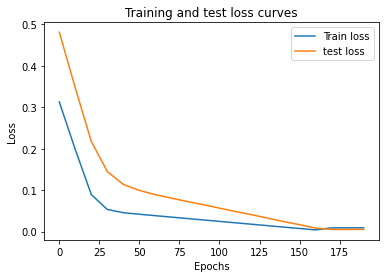

In [67]:
import numpy as np
#plot the loss cureves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label = "Train loss")
plt.plot(epoch_count, np.array(test_loss_values), label = "test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

**Learning Rate**: Learnign rate schedules seek to adjust the learning rate during training by reducing the learning rate according to pre-defined schedule 
Common learning rate schedules includes:-

- Time based decay
- Step decay
- Exponential decay

In [68]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [69]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

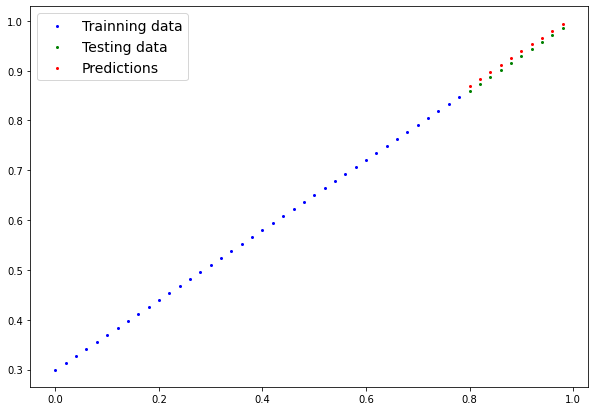

In [70]:
plot_predictions(predictions=y_preds_new)

# Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [73]:
# saving our PyTorch model
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that 

In [77]:
# To load in a saved state_dict we have to instantiate a new instance odf our model class
loaded_model_o = LinearRegression()

# Load the saved state_dict of model_0 (this will update the new instance with upadted parameters)
loaded_model_o.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [78]:
loaded_model_o.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])